In [58]:
import numpy as np
import fitsio as fio
import healpy as hp
import matplotlib.pyplot as plt
import galsim as galsim
import matplotlib.gridspec as gridspec

In [59]:
m_10_kE = fio.FITS('/lsst/troxel/y1a1/y1a1_spt_mcal_10_kE_2048.fits')[-1] # Mass map
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_fmasked.fits')[-1] # Central galaxy catalog
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_fmasked.fits')[-1] # Satellite galaxy catalog
clus_pa = fio.FITS('/lsst/troxel/y1a1/lgt20_clus_ang_2mom.fits')[-1] # Cluster position angle array

In [60]:
# Read in columns
kE = m_10_kE['kE'].read()
cent_ra = np.deg2rad(cent['RA'].read())
cent_dec = np.deg2rad(cent['DEC'].read())
clus_ang = clus_pa.read()

In [61]:
s = 10 # size of cutout (2s by 2s square) in arcminutes
pixel_scale = 10 # size of pixel in arcseconds

In [62]:
grid_ra, grid_dec = np.deg2rad(np.meshgrid(np.linspace(-s/60., s/60., 2*s*60//pixel_scale), np.linspace(-s/60., s/60., 2*s*60//pixel_scale)))

In [63]:
def align_grid(clus_i):
    ra_cent = cent_ra[clus_i]
    dec_cent = cent_dec[clus_i]
    grid_ra_i = grid_ra / np.cos(dec_cent)
    ang_i = clus_ang[clus_i]
    rot = np.array([[np.cos(ang_i), -np.sin(ang_i)], [np.sin(ang_i), np.cos(ang_i)]])
    grid = np.matmul(rot, np.array([grid_ra_i.flatten(), grid_dec.flatten()])) + np.array([[ra_cent], [dec_cent]])
    
    return grid

In [64]:
def norot_grid(clus_i):
    ra_cent = cent_ra[clus_i]
    dec_cent = cent_dec[clus_i]
    grid_ra_i = grid_ra / np.cos(dec_cent)
    grid = np.array([grid_ra_i.flatten(), grid_dec.flatten()]) + np.array([[ra_cent], [dec_cent]])
    
    return grid

In [65]:
def interp_grid(clus_i):
    grid_i = align_grid(clus_i)
    interp = hp.get_interp_val(kE, np.rad2deg(grid_i[0]), np.rad2deg(grid_i[1]), lonlat=True)
    
    return interp

In [66]:
def norot_interp(clus_i):
    grid_i = norot_grid(clus_i)
    interp = hp.get_interp_val(kE, np.rad2deg(grid_i[0]), np.rad2deg(grid_i[1]), lonlat=True)
    
    return interp

In [67]:
def interp_array():
    new_array = np.zeros((len(clus_ang), (2*s*60//pixel_scale)**2))
    for i in range(len(clus_ang)):
        new_array[i] = interp_grid(i)
    
    return new_array

In [68]:
def norot_array():
    new_array = np.zeros((len(clus_ang), (2*s*60//pixel_scale)**2))
    for i in range(len(clus_ang)):
        new_array[i] = norot_interp(i)
    
    return new_array

In [69]:
interp_array = interp_array()

In [70]:
norot_array = norot_array()

In [71]:
interp_sum = np.sum(interp_array, axis=0)

In [72]:
norot_sum = np.sum(norot_array, axis=0)

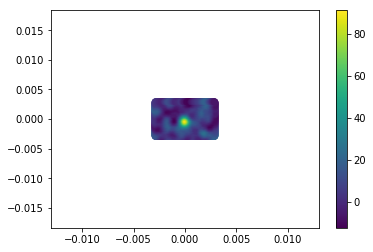

In [73]:
plt.scatter(grid_ra.flatten(), grid_dec.flatten(), c=interp_sum)
plt.colorbar()
plt.show()

In [74]:
interp_image = interp_sum.reshape((2*s*60//pixel_scale, 2*s*60//pixel_scale))

In [95]:
fio.write('/lsst/troxel/y1a1/mass_map_rot_image.fits', interp_image, clobber=True)

In [75]:
norot_image = norot_sum.reshape((2*s*60//pixel_scale, 2*s*60//pixel_scale))

In [96]:
fio.write('/lsst/troxel/y1a1/mass_map_norot_image.fits', norot_image, clobber=True)

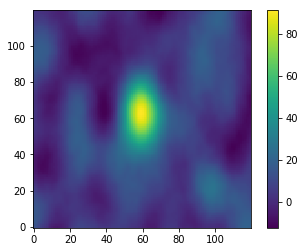

In [76]:
plt.imshow(interp_image, origin='lower')
plt.colorbar()
plt.savefig('/lsst/troxel/y1a1/plots/massmap_2mom.pdf')

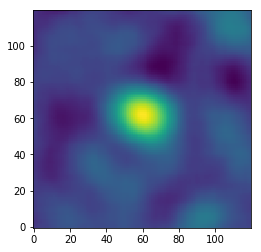

In [77]:
plt.imshow(norot_image, origin='lower')
plt.show()

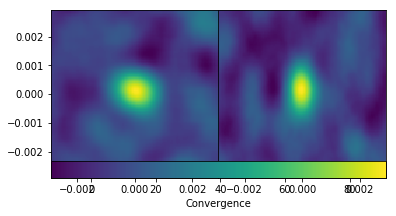

In [105]:
s = 10 # size of cutout (2s by 2s square) in arcminutes
pixel_scale = 10 # size of pixel in arcseconds
grid_ra, grid_dec = np.deg2rad(np.meshgrid(np.linspace(-s/60., s/60., 2*s*60//pixel_scale), np.linspace(-s/60., s/60., 2*s*60//pixel_scale)))

#a should be random, b should be rotated, should cut both down by about 15-25% on each edge (to be more focused on the center cluster and smaller)
plt.figure(figsize=(6,14)) # might need to reverse order of 6,14
gs = gridspec.GridSpec(1,2)
ax1=plt.subplot(gs[0,1])
im = plt.imshow(interp_image,interpolation='none',origin='lower',extent=[np.min(grid_ra), np.max(grid_ra), np.min(grid_dec), np.max(grid_dec)]) #x should be ra, y should be dec, might need to switch ymax, ymin order
ax2=plt.subplot(gs[0,0])
plt.imshow(norot_image,interpolation='none',origin='lower',extent=[np.min(grid_ra), np.max(grid_ra), np.min(grid_dec), np.max(grid_dec)]) #x should be ra, y should be dec, might need to switch ymax, ymin order
fig = plt.gcf()
cbar = fig.colorbar(im, ax=[ax1, ax2], orientation='horizontal',fraction=0.07, anchor=(1.0, 0.0))
cbar.set_label('Convergence')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.,wspace=0.)
plt.savefig('/lsst/troxel/y1a1/plots/massmap.pdf', bbox_inches='tight')
# plt.close()

In [79]:
def measure_shape_moments(img_array, pixel_scale):

    BAD_MEASUREMENT = 1
    CENTROID_SHIFT  = 2
    MAX_CENTROID_SHIFT = 1.

    out = np.zeros(1,dtype=[('e1','f4')]+[('e2','f4')]+[('T','f4')]+[('dx','f4')]+[('dy','f4')]+[('flag','i2')])

    M = e1 = e2 = 0
    im = galsim.Image(img_array, xmin=1, ymin=1, wcs=galsim.PixelScale(pixel_scale))

    try:
        shape_data = im.FindAdaptiveMom(weight=None, strict=False)
    except:
        out['flag'] |= BAD_MEASUREMENT
        return out

    if shape_data.moments_status != 0:
        out['flag'] |= BAD_MEASUREMENT
        return out

    out['dx'] = shape_data.moments_centroid.x - im.true_center.x
    out['dy'] = shape_data.moments_centroid.y - im.true_center.y
    if out['dx']**2 + out['dy']**2 > MAX_CENTROID_SHIFT**2:
        out['flag'] |= CENTROID_SHIFT
        return out

    # Account for the image wcs
    if im.wcs.isPixelScale():
        out['e1'] = shape_data.observed_shape.g1
        out['e2'] = shape_data.observed_shape.g2
        out['T']  = 2 * shape_data.moments_sigma**2 * im.scale**2
    else:
        e1    = shape_data.observed_shape.e1
        e2    = shape_data.observed_shape.e2
        s     = shape_data.moments_sigma
        jac   = im.wcs.jacobian(im.true_center)
        M     = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J     = jac.getMatrix()
        M     = J * M * J.T
        scale = np.sqrt(M/2./s/s)
        e1    = old_div((M[0,0] - M[1,1]), (M[0,0] + M[1,1]))
        e2    = old_div((2.*M[0,1]), (M[0,0] + M[1,1]))
        shear = galsim.Shear(e1=e1, e2=e2)
        out['T']  = M[0,0] + M[1,1]
        out['e1'] = shear.g1
        out['e2'] = shear.g2

    return out, shape_data

In [80]:
out, shape_data = measure_shape_moments(interp_image, pixel_scale)

In [81]:
out

array([(-0.3239921, 0.0398706, 24826.229, -0.01784821, 0.45957318, 0)],
      dtype=[('e1', '<f4'), ('e2', '<f4'), ('T', '<f4'), ('dx', '<f4'), ('dy', '<f4'), ('flag', '<i2')])

In [82]:
np.sqrt(out[0][0]**2 + out[0][1]**2)

0.3264361313662964

In [83]:
np.rad2deg(shape_data.observed_shape.beta.rad)

86.49221493682397

In [84]:
g = shape_data.observed_shape.g

In [85]:
1/((1-g)/(1+g))

1.9692803959680436

In [86]:
out

array([(-0.3239921, 0.0398706, 24826.229, -0.01784821, 0.45957318, 0)],
      dtype=[('e1', '<f4'), ('e2', '<f4'), ('T', '<f4'), ('dx', '<f4'), ('dy', '<f4'), ('flag', '<i2')])

In [87]:
fio.write('/lsst/troxel/y1a1/mass_map_image_2mom.fits', interp_image, clobber=True)